# Sample Processing (Step 0)

In [66]:
# loading needed libraries
library(tidytree)
library(ggpubr)
library(pheatmap)
library(wesanderson)
library(gridExtra)
library(readxl)
library(parallel)
source("func.R")
set.seed(36)

# Lunger cancer samples

In [2]:
# directroy of all results
dir_list <-  list.files("../data/multiple_lung_cancers/",
                        pattern= "_R$", full.names = TRUE)

## Creating Marker Length Table

In [108]:
# tumor P2 in patient TM32 was sampled twice.
# For the rest of analysis, tumor P2a will be considered as the representative samples
l <- lapply(dir_list, get_markerlengths)
markerlengths_tm32b <- bind_rows(l)
markerlengths  <- markerlengths_tm32b  %>% 
    mutate(sample=ifelse(sample=="TM32P2a", "TM32P2", sample))  %>% 
    filter(sample!="TM32P2b")

TM10

TM11

TM12

TM13

TM14

TM15

TM16



In [ ]:
# saving mean length table
write_tsv(markerlengths, "../results/lung_markerlengths.tsv")
write_tsv(markerlengths_tm32b, "../results/lung_markerlengths_tm32b.tsv")

In [67]:
# reading in markerlengths 
markerlengths  <- read_tsv("../results/lung_markerlengths.tsv")
markerlengths_tm32b <- read_tsv("../results/lung_markerlengths_tm32b.tsv")

Rows: 2659 Columns: 4
-- Column specification --------------------------------------------------------
Delimiter: "\t"
chr (3): sample, marker, subject
dbl (1): length

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2684 Columns: 4
-- Column specification --------------------------------------------------------
Delimiter: "\t"
chr (3): sample, marker, subject
dbl (1): length

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


## Creating phylogenetic trees

Getting all possible pairwise combinations for each sample

In [68]:
# find samples
samples <- markerlengths_tm32b$sample %>% unique

combos_wide <- combn(samples, m= 2) %>% as.data.frame()

## make combo table longer
combos_long <- data.frame(a=as.character(combos_wide[1,]), b=as.character(combos_wide[2,]))

## only use combintions from the same subject
combos <- combos_long %>% 
    mutate(sample_a=str_remove(a, "[N|P][:alnum:]+"),
          sample_b=str_remove(b, "[N|P][:alnum:]+"))  %>% 
    filter(sample_a==sample_b) %>% 
    dplyr::select(a, b)  


In [69]:
# finding combination of samples to bootstrap

get_boot_combos <- function(markerlengths, subject_i) {
      # find samples
      samples <- markerlengths$sample %>%
            unique() %>%
            str_subset(paste0(subject_i, "[P|N]"))

      combos_wide <- combn(samples, m = 2) %>% as.data.frame()

      ## make combo table longer
      combos_long <- data.frame(a = as.character(combos_wide[1, ]), b = as.character(combos_wide[2, ]))
}


In [70]:
# function to the find the MRCA of a specific marker combination

boot_mrca <- function(subject_i, subject_markers, n_markers, boot_combos) {

        marker_table <- subject_markers %>%
            slice_sample(n = n_markers, replace = TRUE) %>%
            unnest(data) %>%
            select(subject, sample, marker, length) %>%
            ungroup()

        l1_comb_boot <- lapply(1:nrow(boot_combos), get_l1_r_for_combination, boot_combos, marker_table)

        tbl_boot <- bind_rows(l1_comb_boot) %>%
            mutate(divs = l1 / 9.43139014888478e-05) %>%
            select(a, b, divs)

        tree <- plot_tree(subject_i, tbl_boot)
        tumors <- str_subset(tree$tip.label, "N", negate = TRUE)
        
        findMRCA(tree, tumors, type = "height")
        
    }

In [71]:
# function to plot the tree with a confidence interval around the MRCA 
plot_ci_tree <- function(subject_i, divs_tbl, mrca_boot, markerlengths, l1_tree) {

tree <- plot_tree(subject_i, divs_tbl)

tumors <- str_subset(tree$tip.label, "N", negate = TRUE)

# finding MRCA node and height of the tree with all markers
mrca_node <- findMRCA(tree, tumors)
mrca_height <- findMRCA(tree, tumors, type = "height")

# plotting tree
t <- ggtree(tree, size=2)

# annotating 5th and 95th percentile for confidence interval
t$data <- t$data %>%
  mutate(
    ci_05 = ifelse(node == mrca_node, quantile(mrca_boot, 0.025), NA),
    ci_95 = ifelse(node == mrca_node, quantile(mrca_boot, 0.975), NA),
    CI = "95% CI", label=str_remove_all(label, subject_i)
  )

# finding maximum x value (could also be the end of the CI) to expand coord system
    max_x <- max(t$data$x)
    max_ci <- max(t$data$ci_95, na.rm=TRUE)
    abs_max <- pmax(max_x, max_ci)
    max_y <- max(t$data$y) * 1.2

t_divs <- t + suppressMessages(geom_segment(aes(x=ci_05, y=y, xend=ci_95, yend=y, color=CI),  size=10,  alpha=0.2,
                 show.legend = TRUE)) +
    geom_point2(data= .  %>%  filter(str_detect(label, "P")), 
                aes(x, y), size=16, color= wes_palette("Zissou1")[1]) +
    geom_point2(data= .  %>%  filter(node==mrca_node), 
                size=16, color=wes_palette("Zissou1")[5]) +
    geom_tiplab(size = 12, color = "black", hjust = -0.5) +
      scale_colour_manual(
        na.translate = F, name = "CI", guide = guide_legend(override.aes = list(shape = c(32))),
        values = c(wes_palette("Zissou1")[5])
      ) +
   annotate("point", 0, max_y, size=16, color=wes_palette("Zissou1")[5]) +
   annotate("text", 0.05*abs_max, hjust=0, max_y, size=10, color='black', 
                  label=paste0("Tumor MRCA at division ",round(mrca_height))) + 
    labs(title = paste0(subject_i, " cell division tree"), x = "Divisions from zygote") +
      theme(
        axis.line.x = element_line(size = 1.5),
        axis.title.x = element_text(size = 35, color = "black"),
        axis.text.x = element_text(size = 35, color = "black"),
        axis.ticks.x = element_line(color = "black", size = 1),
        axis.ticks.length.x = unit(0.2, "cm"), plot.title = element_text(size = 35),
        text = element_text(size = 18, color = "black"), axis.line = element_line(color = "black", size = 1),
        legend.position = c(0.85, 0.2), legend.title = element_blank(), legend.text = element_text(size = 30)
      ) +
    xlim(0, abs_max*1.2) 

ggsave(paste0("../plots/Supplementary_figures/lung_trees/", subject_i, "_nj_tree.pdf"),
  t_divs,
  height = 7,
  width = 26
)

# create heatmap
  heatmap  <-  create_heatmap(subject_i, markerlengths)
  t_divs_hm <- t_divs + ggtitle(subject_i)
  pdf(paste0("../plots/Supplementary_figures/lung_trees_hm/", subject_i, "_tree_hm.pdf"), width=14*2, height=12)
  grid.arrange(t_divs_hm, heatmap[[4]], widths = 1:2, vp=grid::viewport(width=1, height=0.7))
  dev.off()

# save tree with untransformed l1 distance:
t$data  <- t$data %>%
  mutate(across(c(branch.length, branch, x, ci_05, ci_95), ~ .x*9.43139014888478e-05))

# finding maximum x value (could also be the end of the CI) to expand coord system
    max_x <- max(t$data$x)
    max_ci <- max(t$data$ci_95, na.rm=TRUE)
    abs_max <- pmax(max_x, max_ci)
    max_y <- max(t$data$y) * 1.2
    mrca_height <- mrca_height*9.43139014888478e-05

# saving l1 tree only if needed
if (l1_tree) { plot(t + suppressMessages(geom_segment(aes(x=ci_05, y=y, xend=ci_95, yend=y, color=CI),  size=10,  alpha=0.2,
                 show.legend = TRUE)) +
    geom_point2(data= .  %>%  filter(str_detect(label, "P")), 
                aes(x, y), size=16, color= wes_palette("Zissou1")[1]) +
    geom_point2(data= .  %>%  filter(node==mrca_node), 
                size=16, color=wes_palette("Zissou1")[5]) +
    geom_tiplab(size = 12, color = "black", hjust = -0.4) +
      scale_colour_manual(
        na.translate = F, name = "CI", guide = guide_legend(override.aes = list(shape = c(32))),
        values = c(wes_palette("Zissou1")[5])
      ) +
   annotate("point", 0, max_y, size=16, color=wes_palette("Zissou1")[5]) +
   annotate("text", 0.03*abs_max, hjust=0, max_y, size=10, color='black', 
                  label=paste0("Tumor MRCA at L1: ",round(mrca_height, digits=2))) + 
    labs(title = paste0(subject_i, " L1 distance tree"), x = "L1 from zygote") +
      theme(
        axis.line.x = element_line(size = 1.5),
        axis.title.x = element_text(size = 35, color = "black"),
        axis.text.x = element_text(size = 35, color = "black"),
        axis.ticks.x = element_line(color = "black", size = 1),
        axis.ticks.length.x = unit(0.2, "cm"), plot.title = element_text(size = 35),
        text = element_text(size = 18, color = "black"), axis.line = element_line(color = "black", size = 1),
        legend.position = c(0.85, 0.2), legend.title = element_blank(), legend.text = element_text(size = 30)
      ) +
    xlim(0, abs_max*1.2)) }

return(tree)
}

In [72]:
# function to find the position of the MRCA of every tumor pair on the tree constructed with all tumors
get_mrca_heights <- function(tree, subject_i) {

p1_p2 <- fastHeight(tree, str_subset(tree$tip.label, "P1"), str_subset(tree$tip.label, "P2")[1])


if (any(str_detect(tree$tip.label, "P3"))) {
    
    p1_p3 <- fastHeight(tree, str_subset(tree$tip.label, "P1"), str_subset(tree$tip.label, "P3"))
    
    p2_p3 <- fastHeight(tree, str_subset(tree$tip.label, "P2"), str_subset(tree$tip.label, "P3"))
    
    all <- min(p1_p2, p1_p3, p2_p3)    

} else {
   p1_p3 <- NA 
   p2_p3 <- NA
   all <- p1_p2
}    

# mrca of all tumors 

l  <- list(subject=subject_i, all_mrca=all, p1_p2_mrca=p1_p2, p1_p3_mrca=p1_p3, p2_p3_mrca=p2_p3)    
return(l)
    
}

In [73]:
bootstrap_mrca <- function(subject_i, markerlengths, divs_tbl, l1_tree) {
    
    # nesting markers
    subject_markers <- markerlengths %>%
        filter(subject == subject_i) %>% 
        group_by(subject, marker) %>% 
        nest %>% 
        ungroup 

    # getting combos to bootstrap through
    boot_combos <- get_boot_combos(markerlengths, subject_i)

    n_markers <- length(unique(subject_markers$marker))

    mrca_boot <- replicate(1000, boot_mrca(subject_i, subject_markers, n_markers, boot_combos))

    subject_tbl <- divs_tbl %>%
        filter(str_detect(a, paste0(subject_i, "[P|N]")))

    tree <- plot_ci_tree(subject_i, subject_tbl, mrca_boot, markerlengths_tm32b, l1_tree)

    l <- get_mrca_heights(tree, subject_i)

    return(l)
}

In [74]:
# create a table for the L1 of non-bootstrapped marker lengths 
non_boot_l1 <- lapply(1:nrow(combos), get_l1_r_for_combination, combos, markerlengths_tm32b)
non_boot_l1 <- rbindlist(non_boot_l1)

In [75]:
subjects <- unique(markerlengths_tm32b$subject)
lung_l1_tbl <- non_boot_l1 %>%
    mutate(divs = l1 / 9.43139014888478e-05)
mrca_list <- mclapply(subjects, bootstrap_mrca, markerlengths_tm32b, lung_l1_tbl, FALSE)

Saving L1 tree of case TM32 for Figure1:

Warning message:
"Removed 6 rows containing missing values (`geom_segment()`)."
Warning message:
"Removed 6 rows containing missing values (`geom_segment()`)."
Warning message:
"Removed 6 rows containing missing values (`geom_segment()`)."


[[1]]
[[1]]$subject
[1] "TM32"

[[1]]$all_mrca
[1] 401.2332

[[1]]$p1_p2_mrca
[1] 401.2332

[[1]]$p1_p3_mrca
[1] NA

[[1]]$p2_p3_mrca
[1] NA

Warning message:
"Removed 6 rows containing missing values (`geom_segment()`)."


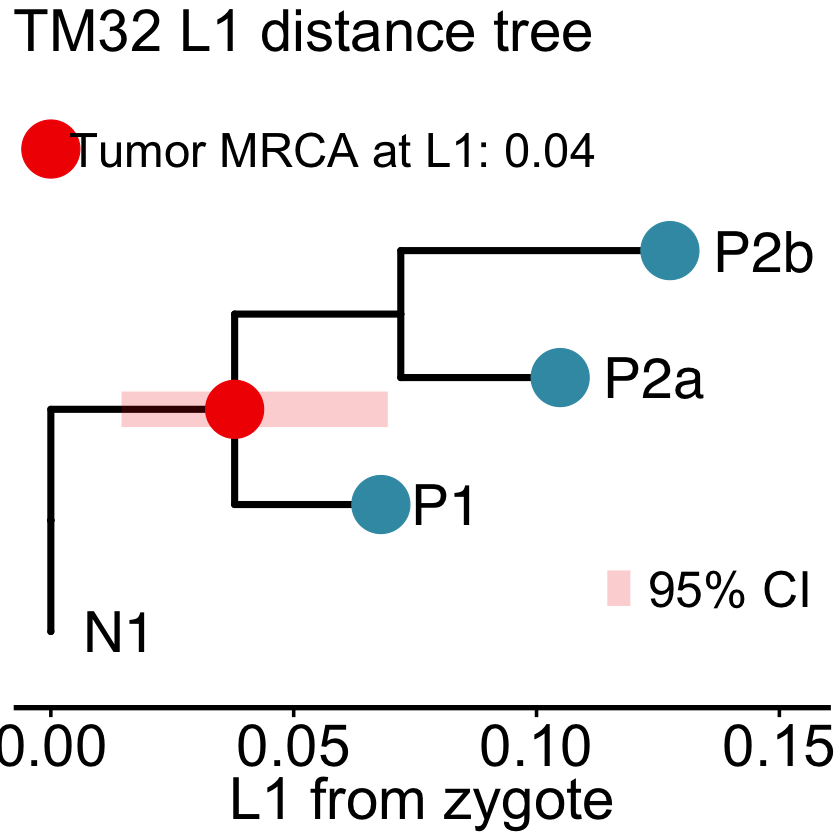

In [ ]:
lapply("TM32", bootstrap_mrca, markerlengths_tm32b, lung_l1_tbl, TRUE)
ggsave("../plots/Figure1/tm23_l1_tree.pdf",
  height = 7,
  width = 26
)

Numbers for Figure 1 text:

In [ ]:
cell_divs_tbl <- lung_l1_tbl


subject_i <- "TM32"

 subject_i <- paste0(subject_i, "(?=[:alpha:])")
    sample_tbl <- cell_divs_tbl %>% filter(str_detect(a, subject_i), 

        str_detect(b, subject_i)) %>% select(a, b, l1)
    root_sample <- str_subset(unique(c(sample_tbl$a, sample_tbl$b)), 
        "N")[1]

    sample_tbl <- sample_tbl %>% filter((a == root_sample) | 
        str_detect(a, "N", negate = TRUE), (b == root_sample) | 
        str_detect(b, "N", negate = TRUE))

    zero_tbl <- tibble(a = unique(sample_tbl$a), b = unique(sample_tbl$a), 
        l1 = 0) %>% bind_rows(tibble(a = unique(sample_tbl$b), 
        b = unique(sample_tbl$b), l1 = 0)) %>% distinct()

    dist_mat_int <- sample_tbl %>% bind_rows(zero_tbl) %>% pivot_wider(names_from = a, 
        values_from = l1)

    dist_mat <- dist_mat_int[match(colnames(dist_mat_int), dist_mat_int$b) %>% 
        na.omit, ] %>% column_to_rownames("b")

    tree <- nj(as.dist(dist_mat))

    tm32_tree <- phytools::reroot(tree, node.number = which(tree$tip.label == 
        root_sample))

    tm32_ggtree <- ggtree(tm32_tree)

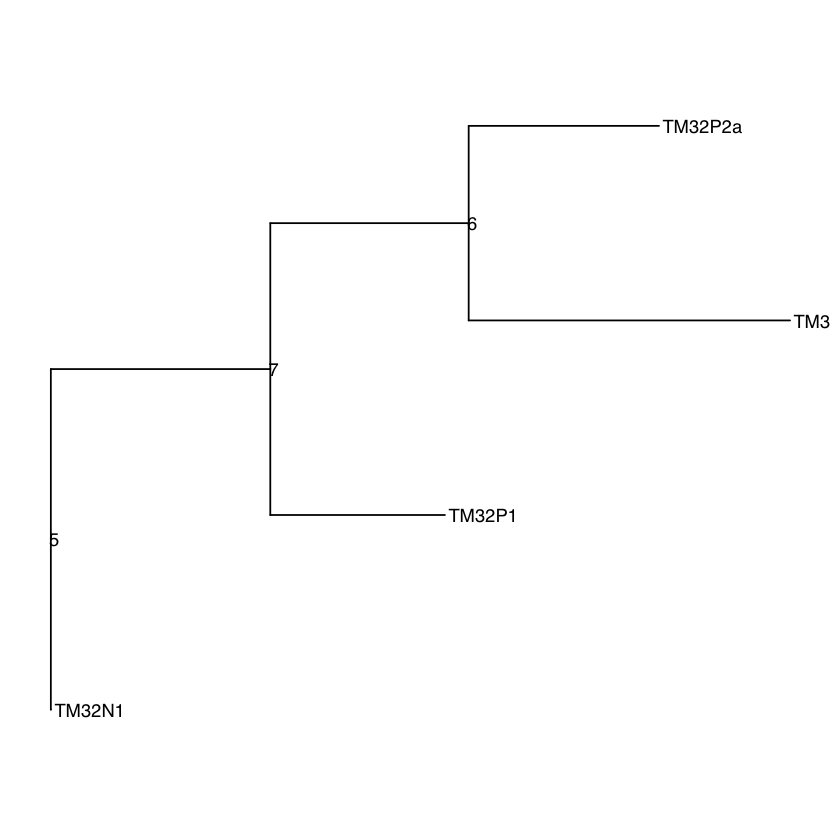

In [ ]:
tm32_ggtree +
    geom_tiplab(aes(label=label)) +
    geom_nodelab(aes(label=node))

In [ ]:
tm32_ggtree$data

parent,node,branch.length,label,isTip,x,y,branch,angle
<int>,<int>,<dbl>,<chr>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>
5,1,0.00000000,TM32N1,TRUE,0.00000000,1.000,0.00000000,90.00
7,2,0.03011097,TM32P1,TRUE,0.06795284,2.000,0.05289735,180.00
6,3,0.03281486,TM32P2a,TRUE,0.10486442,4.000,0.08845699,360.00
6,4,0.05541156,TM32P2b,TRUE,0.12746112,3.000,0.09975534,270.00
5,5,0.00000000,NA,FALSE,0.00000000,1.875,0.00000000,168.75
7,6,0.03420769,NA,FALSE,0.07204956,3.500,0.05494571,315.00
5,7,0.03784187,NA,FALSE,0.03784187,2.750,0.01892093,247.50


In [ ]:
lapply("TM18", bootstrap_mrca, markerlengths_tm32b, lung_l1_tbl, F)
ggsave("../plots/Figure5/tm18_divs_tree.pdf",
  height = 6,
  width = 15
)

Warning message:
"Removed 4 rows containing missing values (`geom_segment()`)."
Warning message:
"Removed 4 rows containing missing values (`geom_segment()`)."


[[1]]
[[1]]$subject
[1] "TM18"

[[1]]$all_mrca
[1] 821.6598

[[1]]$p1_p2_mrca
[1] 821.6598

[[1]]$p1_p3_mrca
[1] NA

[[1]]$p2_p3_mrca
[1] NA

Warning message:
"Removed 4 rows containing missing values (`geom_segment()`)."


In [ ]:
lapply("TM2", bootstrap_mrca, markerlengths_tm32b, lung_l1_tbl, F)
ggsave("../plots/Figure4/tm2_divs_tree.pdf",
  height = 6,
  width = 15
)

Warning message:
"Removed 4 rows containing missing values (`geom_segment()`)."
Warning message:
"Removed 4 rows containing missing values (`geom_segment()`)."


[[1]]
[[1]]$subject
[1] "TM2"

[[1]]$all_mrca
[1] 290.8919

[[1]]$p1_p2_mrca
[1] 290.8919

[[1]]$p1_p3_mrca
[1] NA

[[1]]$p2_p3_mrca
[1] NA

Warning message:
"Removed 4 rows containing missing values (`geom_segment()`)."


Saving the data

In [ ]:
# saving both tables
non_boot_l1  %>% 
    mutate(a=ifelse(a=="TM32P2a", "TM32P2", a),
          b=ifelse(b=="TM32P2a", "TM32P2", b),
          subject=str_remove(a, "[N|P][:alnum:]+"), 
          tumor_a=str_extract(a, "[N|P][:alnum:]+"),
          tumor_b=str_extract(b, "[N|P][:alnum:]+"))    %>% 
    filter(a!="TM32P2b", b!="TM32P2b")  %>% 
write_tsv("../results/lung_pairwise_l1.tsv")

lung_l1_tbl %>%
    mutate(subject=str_remove(a, "[N|P][:alnum:]+"), 
          tumor_a=str_extract(a, "[N|P][:alnum:]+"),
          tumor_b=str_extract(b, "[N|P][:alnum:]+")) %>% 
    write_tsv("../results/lung_pairwise_l1_tm32b.tsv")

In [ ]:
# saving the mrca of all tumors
bind_rows(mrca_list)  %>%  
    write_tsv("../results/lung_mrca_table.tsv")

# Colorectal cancer trees

In [76]:
# renaming sample names with their organ of origin for data from the Science paper

# function to read files  
read_annotation_files  <- function(annotation_file) {
read_tsv(annotation_file)  %>% 
    rename(sample=Sample_ID, new_id=Real_Sample_ID)
                            }
annotation_files  <- list.files("../data/science_2017/AnnotationFiles/", 
                                full.names = TRUE)

tbl_list  <- lapply(annotation_files, read_annotation_files)
sample_names  <- bind_rows(tbl_list)

Rows: 18 Columns: 2
-- Column specification --------------------------------------------------------
Delimiter: "\t"
chr (2): Sample_ID, Real_Sample_ID

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 15 Columns: 2
-- Column specification --------------------------------------------------------
Delimiter: "\t"
chr (2): Sample_ID, Real_Sample_ID

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 11 Columns: 2
-- Column specification --------------------------------------------------------
Delimiter: "\t"
chr (2): Sample_ID, Real_Sample_ID

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 13 Columns: 2
-- Column specification -----------------------------------

### Extracting marker lengths
Getting the minimum number of marker all samples agree on, as long as that's more than 70% of the maximum possible markers 

In [77]:
# function to get markers that are present in all samples
get_sampler_marker  <- function(sample_i, marker_tbl) {
    
    marker_tbl  %>% 
    filter(sample==sample_i)  %>% 
    pull(marker)  %>% 
    unique()
}

get_minimum_marker_table  <- function(subject_i, markerlengths){

marker_tbl <-  markerlengths  %>% 
    filter(subject==subject_i)  %>% 
    group_by(sample)  %>% 
    add_count(sample)  %>% 
    ungroup()  %>% 
    mutate(minimum_markers = max(n)*0.7) %>% 
    filter(n>minimum_markers) 
    
samples  <- unique(marker_tbl$sample)
marker_list  <- lapply(samples, get_sampler_marker, marker_tbl)
common_markers  <- Reduce(intersect, marker_list)

n_common_markers  <- length(common_markers)

markerlengths  %>% 
    filter(subject==subject_i, marker %in% common_markers)   %>% 
    group_by(sample)  %>% 
    add_count(sample)  %>% 
    filter(n==n_common_markers)  %>% 
    select(-n)
    
    }

In [78]:
# directroy of the results from the Reiter et al 2020 Nat Gen paper
dir_list <- list.files("../data/natgen_2020/",
    pattern = "_R$", full.names = TRUE
) 

l <- purrr::map(dir_list, get_markerlengths)
markerlengths_natgen <- bind_rows(l) 

## directroy of the results from the Naxerova et al 2018 Science paper
dir_list <-  list.files("../data/science_2017/", 
                        pattern= "_R$", full.names=TRUE)
# directoy name for science cohort needs to include the string "science"
l <- purrr::map(dir_list, get_markerlengths)
markerlengths_science  <- bind_rows(l)

C100



C102

C11

C57

C6

C70

C80

C83

C84

C85

C89

C90

C92

C93

C94

C95

C96

C97

C98

C99

C12

C31

C36

C38

C39

C45

C46

C51

C53

C57

C58

C59

C61

C63

C65

C66

C69

C77

C79



In [79]:
# processing data from Nat Gen paper
subjects  <- unique(markerlengths_natgen$subject)
minimum_marker_tbls  <- lapply(subjects, get_minimum_marker_table, markerlengths_natgen)
minimum_markerlengths_natgen <- bind_rows(minimum_marker_tbls) 

In [80]:
# renaming samples from Science paper 
# getting all marker lengths from normal 
markerlengths_science_renamed  <- left_join(markerlengths_science, sample_names)  %>% 
    mutate(sample=paste0(subject, new_id))  %>% 
    select(1:4)

# getting all marker lengths from normal 
subjects  <- unique(markerlengths_science_renamed$subject)
minimum_marker_tbls_science  <- lapply(subjects, get_minimum_marker_table, markerlengths_science_renamed)
minimum_markerlengths_science  <- bind_rows(minimum_marker_tbls_science) %>% 
    # for the science cohort, the normal marker length needs to be subteracted at this point
    group_by(subject, marker) %>% 
    mutate(length = length - length[sample==str_subset(sample, "N")[1]])   %>% 
    #removing subject C39 for lack of obvious primary tumor and C57 because it is included in the Nat Gen cohort
    filter(!str_detect(sample, "C39|C57"))

Joining with `by = join_by(sample)`


### Converting markerlengths into L1 distance and cell divisions
Data from Reiter et al. Nat Gen 2020.

In [81]:
# getting intrapatient sample combinations

# find samples
samples <- minimum_markerlengths_natgen$sample %>% unique

combos_wide <- combn(samples, m= 2) %>% as.data.frame()

## make combo table longer
combos_long <- data.frame(a=as.character(combos_wide[1,]), b=as.character(combos_wide[2,]))

## only use combintions from the same subject
combos <- combos_long %>% 
    mutate(sample_a=str_remove(a, "[N|P|M|L|Ad][:alnum:]+"),
          sample_b=str_remove(b, "[N|P|M|L|Ad][:alnum:]+"))  %>% 
    filter(sample_a==sample_b) %>% 
    dplyr::select(a, b)  


In [82]:
# getting l1 for all intrapatient sample combinations in the cohort
l1 <- lapply(1:nrow(combos), get_l1_r_for_combination, combos, minimum_markerlengths_natgen)
natgen_cell_divs  <- bind_rows(l1)  %>% 
    # different mutation rates for MSI and MSS tumors
    mutate(divs=ifelse(str_detect(a, "C92[:alpha:]|C95[:alpha:]|C6[:alpha:]|C38[:alpha:]|C12[:alpha:]|C102[:alpha:]"), l1/0.000471905953288399, l1/9.43139014888478e-05))

Data from Naxerova et al. Science 2017.

In [83]:
# getting intrapatient sample combinations

# find samples
samples <- minimum_markerlengths_science$sample %>% unique

combos_wide <- combn(samples, m= 2) %>% as.data.frame()

## make combo table longer
combos_long <- data.frame(a=as.character(combos_wide[1,]), b=as.character(combos_wide[2,]))

## only use combintions from the same subject
combos <- combos_long %>% 
    mutate(sample_a=str_remove(a, "[N|P|M|L|Ad][:alnum:]+"),
          sample_b=str_remove(b, "[N|P|M|L|Ad][:alnum:]+"))  %>% 
    filter(sample_a==sample_b) %>% 
    dplyr::select(a, b)  

In [84]:
# getting l1 for all intrapatient sample combinations in the cohort
l1 <- lapply(1:nrow(combos), get_l1_r_for_combination, combos, minimum_markerlengths_science)
science_cell_divs  <- bind_rows(l1)  %>% 
    # different mutation rates for MSI and MSS tumors
    mutate(divs=ifelse(str_detect(a, "C92[:alpha:]|C95[:alpha:]|C6[:alpha:]|C38[:alpha:]|C12[:alpha:]|C102[:alpha:]"), l1/0.000471905953288399, l1/9.43139014888478e-05))

In [85]:
l1_tbl <- bind_rows(science_cell_divs, natgen_cell_divs) 

In [86]:
# saving l1 and markerlength data
crc_markerlengths <- bind_rows(minimum_markerlengths_science, minimum_markerlengths_natgen)  

crc_markerlengths %>% 
    write_tsv("../results/crc_markerlengths.tsv")
l1_tbl %>% 
    write_tsv("../results/crc_pairwise_l1.tsv")

## Plotting all trees with cell divisions timing and extracting MRCA divisions

In [87]:
plot_trees <- TRUE

### Nat Gen Trees

In [88]:
subjects  <- unique(minimum_markerlengths_natgen$subject)
mrca_list  <- lapply(subjects, plot_tree_hm_extract_mrcas, natgen_cell_divs, minimum_markerlengths_natgen, plot_trees)

C100

C102

C11

C57

C6

C70

C80

C83

C84

C85

C89

C90

C92

C93

C94

C95

C96

C97

C98

C99



### Science Trees

In [89]:
subjects  <- unique(minimum_markerlengths_science$subject)
mrca_list_science  <- lapply(subjects, plot_tree_hm_extract_mrcas, science_cell_divs, minimum_markerlengths_science, plot_trees)

C12



C31

C36

C38

C45

C46

C51

C53

C58

C59

C61

C63

C65

C66

C69

C77

C79



In [17]:
mrca_tbl <- bind_rows(mrca_list, mrca_list_science)

In [18]:
bind_rows(mrca_list, mrca_list_science)  %>% 
    write_tsv("../results/crc_mrca_table.tsv")

### Divergence timing
Timing the mrca of lesions with the primary tumor:

In [23]:
subjects  <- unique(minimum_markerlengths_natgen$subject)

natgen_divergence  <- lapply(subjects, timing_pt_divergence, natgen_cell_divs)

subjects  <- unique(minimum_markerlengths_science$subject)  %>% 
# C63 only has one sample of the primary tumor, so there is no ground truth in terms of divergence timing
    str_subset("C63", negate=TRUE)
science_divergence  <- lapply(subjects, timing_pt_divergence, science_cell_divs)

divergence_timing  <- bind_rows(natgen_divergence, science_divergence)

C100

C102

C11

C57

C6

C70

C80

C83

C84

C85

C89

C90

C92

C93

C94

C95

C96

C97

C98

C99

C12

C31

C36

C38

C45

C46

C51

C53

C58

C59

C61

C65

C66

C69

C77

C79



In [24]:
divergence_timing %>%
    write_tsv("../results/crc_divergence_timing.tsv")

## Boostrapping trees

In [25]:
# finding combination of samples to bootstrap

get_boot_combos <- function(markerlengths, subject_i) {
      
      # find samples
      samples <- markerlengths %>% 
            filter(subject==subject_i) %>% 
            pull(sample) %>%
            unique()

      combos_wide <- combn(samples, m = 2) %>% as.data.frame()

      ## make combo table longer
      combos_long <- data.frame(a = as.character(combos_wide[1, ]), b = as.character(combos_wide[2, ]))
}


In [26]:
# function to the find the MRCA of a specific marker combination

boot_mrca <- function(i, subject_i, subject_markers, n_markers, boot_combos) {
        
        marker_table <- subject_markers %>%
            slice_sample(n = n_markers, replace = TRUE) %>%
            unnest(data) %>%
            select(subject, sample, marker, length) %>%
            ungroup()

        l1_comb_boot <- lapply(1:nrow(boot_combos), get_l1_r_for_combination, boot_combos, marker_table)

        tbl_boot <- bind_rows(l1_comb_boot) %>%
            mutate(divs=ifelse(str_detect(a, "C92[:alpha:]|C95[:alpha:]|C6[:alpha:]|C38[:alpha:]|C12[:alpha:]|C102[:alpha:]"), l1/0.000471905953288399, l1/9.43139014888478e-05)) %>%
            select(a, b, divs)

        tree <- plot_tree(subject_i, tbl_boot)

        return(tree)
        
    }

In [27]:
bootstrap_mrca <- function(subject_i, markerlengths, divs_tbl) {
    
    # nesting markers
    subject_markers <- markerlengths %>%
        filter(subject == subject_i) %>% 
        group_by(subject, marker) %>% 
        nest %>% 
        ungroup 

    # getting combos to bootstrap through
    boot_combos <- get_boot_combos(markerlengths, subject_i)

    n_markers <- length(unique(subject_markers$marker))

    # number of bootstrap reps
    reps <- 1000
    mrca_boot <- mclapply(1:reps, boot_mrca, subject_i, subject_markers, n_markers, boot_combos)

    return(mrca_boot)
}

In [37]:
subjects <- unique(crc_markerlengths$subject)
l <- map(subjects, \(subject) bootstrap_mrca(subject, crc_markerlengths, l1_tbl), .progress=T)

 =>-----------------------------    3% |  ETA:  5h

 ==>----------------------------    5% |  ETA:  5h

 ==>----------------------------    8% |  ETA:  4h

 ===>---------------------------   11% |  ETA:  3h

 ====>--------------------------   14% |  ETA:  3h

 =====>-------------------------   16% |  ETA:  3h

 ======>------------------------   19% |  ETA:  2h

 ======>------------------------   22% |  ETA:  2h

 =======>-----------------------   24% |  ETA:  2h

 ========>----------------------   27% |  ETA:  2h

 =========>---------------------   30% |  ETA:  2h

 ==========>--------------------   32% |  ETA:  2h

 ===========>-------------------   35% |  ETA:  2h

 ===========>-------------------   38% |  ETA:  2h

 ============>------------------   41% |  ETA:  2h

 =============>-----------------   43% |  ETA:  1h

 ==============>----------------   46% |  ETA:  1h

 ===============>---------------   49% |  ETA:  1h

 ===============>---------------   51% |  ETA:  1h

 ===========

In [38]:
saveRDS(l, "../results/bootstrapped_crc_trees.rds")